## Yield Spread model
This notebook implements a model to predict yield spreads from reference and trade history data. The model uses an attention layer between the two LSTM layers. The model is trained on data from 1 June 2022 to 31 October 2022. The test set is the month of November. 

Last Update: Tested the impact of exclusions on MAE

The notebook contains a table with the results of all experiments. FICC treasury spreads is the spread calculated by taking the difference of the FICC ycl and the treasury yield for the same maturity. We also experiment with feeding the treasury rates for all maturities. Another feature is the difference in the treasury rate for the target trade and the treasury rate a day before. We also experiment with the Ted rate, which is the difference between the 10-year treasury rate and 2-year treasury rate. A positive ted rate shows a positive outlook for the economy and vice-versa for a negative ted rate.

I have added an additional table that includes the results for different exclusions. 

Note: Change NUM_FEATURES to 6 if you want to train with treasury spreads

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
tf.__version__

'2.11.0'

Setting the environment variables

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="mitas_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [4]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [5]:
storage_client = storage.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

#### Data Preparation
We grab the data from a GCP bucket. The data is prepared using the ficc python package. More insight on how the data is prepared can be found [here](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb)

In [7]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
# with fs.open('ahmad_data/processed_data_2022-10-24-20:56.pkl') as f:
# with fs.open('ahmad_data/processed_data_2022-10-24-20:56_c_spread.pkl') as f:
# with fs.open('ahmad_data/processed_data_2022-12-02-17:52.pkl') as f:
with fs.open('ficc_training_data_latest/processed_data_2022-12-28-09:42.pkl') as f:
    data = pd.read_pickle(f)

In [8]:
data.trade_date.max()

Timestamp('2022-11-30 00:00:00')

To remove volatile days we uses the difference in ficc yield curve level. The difference is taken between the ycl at trade date and the ycl a day before. 

**In this run of the notebook we are not excluding any trades based on volatility. The code is left here for future experimentation**

In [10]:
# data['diff_ycl'] = np.abs(data.ficc_ycl - data.day_before_ycl)

In [11]:
# data.hist('diff_ycl', bins=20)

In [12]:
len(data)

5353947

## Calculating alternative labels
Same_ys is the yield spread for the current trade relative to the current date that is labeled last_calc_day_cat

In [13]:
%%time
ytw = data['yield']
print( ((ytw - data.yield_spread - data.ficc_ycl)**2).mean() )

lys = data.last_yield_spread

last_ytw = 0 * ytw
same_ys = 0 * lys

sub = data.last_calc_day_cat == 0
last_ytw[sub] = lys[sub] + data[sub].last_ficc_ycl_to_next_call 
same_ys[sub] =  ytw[sub] - data[sub].ficc_ycl_to_next_call

sub = data.last_calc_day_cat == 1
last_ytw[sub] = lys[sub] + data[sub].last_ficc_ycl_to_par_call
same_ys[sub] =  ytw[sub] - data[sub].ficc_ycl_to_par_call

sub = data.last_calc_day_cat == 2
last_ytw[sub] = lys[sub] + data[sub].last_ficc_ycl_to_maturity 
same_ys[sub] =  ytw[sub] - data[sub].ficc_ycl_to_maturity 

sub = data.last_calc_day_cat == 3
last_ytw[sub] = lys[sub] + data[sub].last_ficc_ycl_to_refund 
same_ys[sub] =  ytw[sub] - data[sub].ficc_ycl_to_refund 

data['same_ys'] = same_ys
data['ytw'] = ytw
data['last_ytw'] = last_ytw

5.6754321277839745e-30
CPU times: user 9.83 s, sys: 17.8 s, total: 27.6 s
Wall time: 36.2 s


A few trades are dropped because there are no trades in history. Since there are no trades in history the same_ys is Null.

In [14]:
len(data)

5353947

In [15]:
data.dropna(subset=['same_ys'],inplace=True)

In [16]:
len(data)

5351422

#### Adding features from Charles's notebook

In [17]:
%%time
data['ttypes'] = (data.last_trade_type.astype(str) + data.trade_type.astype(str)).astype('category')
data['diff_size'] = (data.par_traded - data.last_size).astype(np.float32)
data['abs_last_yield_spread'] = np.abs(data['last_yield_spread'])
data['abs_diff_size'] = np.abs(data['diff_size'])
data['days_duration'] = (data.last_calc_date - data.last_settlement_date).dt.days

CPU times: user 1.17 s, sys: 195 ms, total: 1.37 s
Wall time: 1.36 s


In [18]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']

This feature is used to check if there are any NaN values in the trade history. **It is not used to train the model**

In [19]:
%%time
data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))

/Users/user/miniforge3/lib/python3.10/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


CPU times: user 12.1 s, sys: 1.73 s, total: 13.8 s
Wall time: 18.2 s


Here is a list of exclusions that we will be experimenting with. The model is trained without any exclusions. The exclusions are applied to the test set to see the impact on accuracy. The code below (as comments) shows how exclusion is applied on the test set
<ul>
    <li>Private placement/subject to SEC regulation 144A</li>
    <li>Callable less than a year in the future </li>
    <li>Maturity less than a year in the future and more than 30 years in the future</li>
    <li>Territories (VI, GU, PR)</li>
<ul>

In [20]:
# data = data[data.sale_type != 4]
# data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
# data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
# data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
# data = data[data.days_to_maturity < np.log10(30000)]
# data = data[data.incorporated_state_code != 'PR']
# data = data[data.incorporated_state_code != 'VI']
# data = data[data.incorporated_state_code != 'GU']

In [21]:
len(data)

5351422

For the purpose of plotting, not used in training

In [22]:
data.purpose_sub_class.fillna(0, inplace=True)

Adding the concatenated trade type, target trade attention, and treasury spread over ficc ycl in PREDICTORS to train the model.

In [23]:
if 'ttypes' not in CATEGORICAL_FEATURES:
    CATEGORICAL_FEATURES.append('ttypes')
    PREDICTORS.append('ttypes')

In [24]:
data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100

In [25]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

In [26]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

In [27]:
# if 'ted-rate' not in PREDICTORS:
#     PREDICTORS.append('ted-rate')
#     NON_CAT_FEATURES.append('ted-rate')

In [28]:
# if 'corporate_spread' not in PREDICTORS:
#     PREDICTORS.append('corporate_spread')
#     NON_CAT_FEATURES.append('corporate_spread')

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are not used in training. These features are used to uderstand the results from the model.

In [29]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'same_ys',
                     'trade_history_sum',
                     'sale_type',
                     'days_to_refund',
                     'is_called']

In [30]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]

In [31]:
len(processed_data)

5351422

Used to drop NaN values in trade history.

In [32]:
processed_data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])

In [33]:
len(processed_data)

5351409

In [34]:
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)

In [35]:
processed_data.dropna(inplace=True, subset=PREDICTORS)

In [36]:
len(processed_data)

5351409

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [37]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
ttypes


#### Splitting the data into train and test sets



In [38]:
train_dataframe = processed_data[(processed_data.trade_date < '11-01-2022')]

In [39]:
test_dataframe = processed_data[(processed_data.trade_date >= '11-01-2022') & (processed_data.trade_date <= '11-30-2022') ]

In [40]:
len(train_dataframe)

4243916

In [41]:
len(test_dataframe)

1107493

Converting data into format suitable for the model

In [42]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [43]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.yield_spread
# y_train = train_dataframe.same_ys

CPU times: user 5 s, sys: 1.07 s, total: 6.08 s
Wall time: 6.45 s


In [44]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.yield_spread
# y_test = test_dataframe.same_ys

CPU times: user 1.26 s, sys: 309 ms, total: 1.57 s
Wall time: 1.64 s


In [45]:
x_train[0].shape

(4243916, 5, 6)

In [46]:
x_test[2].shape

(1107493, 27)

## LightGBM

In [47]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features','yield_spread','calc_day_cat'])
    return df

In [48]:
trainlabel = train_dataframe.yield_spread
testlabel = test_dataframe.yield_spread

In [49]:
gbt_td = gbmprep(train_dataframe[PREDICTORS])

In [50]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [51]:
%%time
gbtmodel.fit(gbt_td, trainlabel) 

/Users/user/miniforge3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 3min 41s, sys: 31 s, total: 4min 12s
Wall time: 1min 10s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [52]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(test_dataframe[PREDICTORS]) )
delta = testlabel - gbt_pred
print( delta.mean(), delta.abs().mean() )

1.4854011215273268 14.581024103325904
CPU times: user 50.5 s, sys: 484 ms, total: 51 s
Wall time: 6.13 s


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

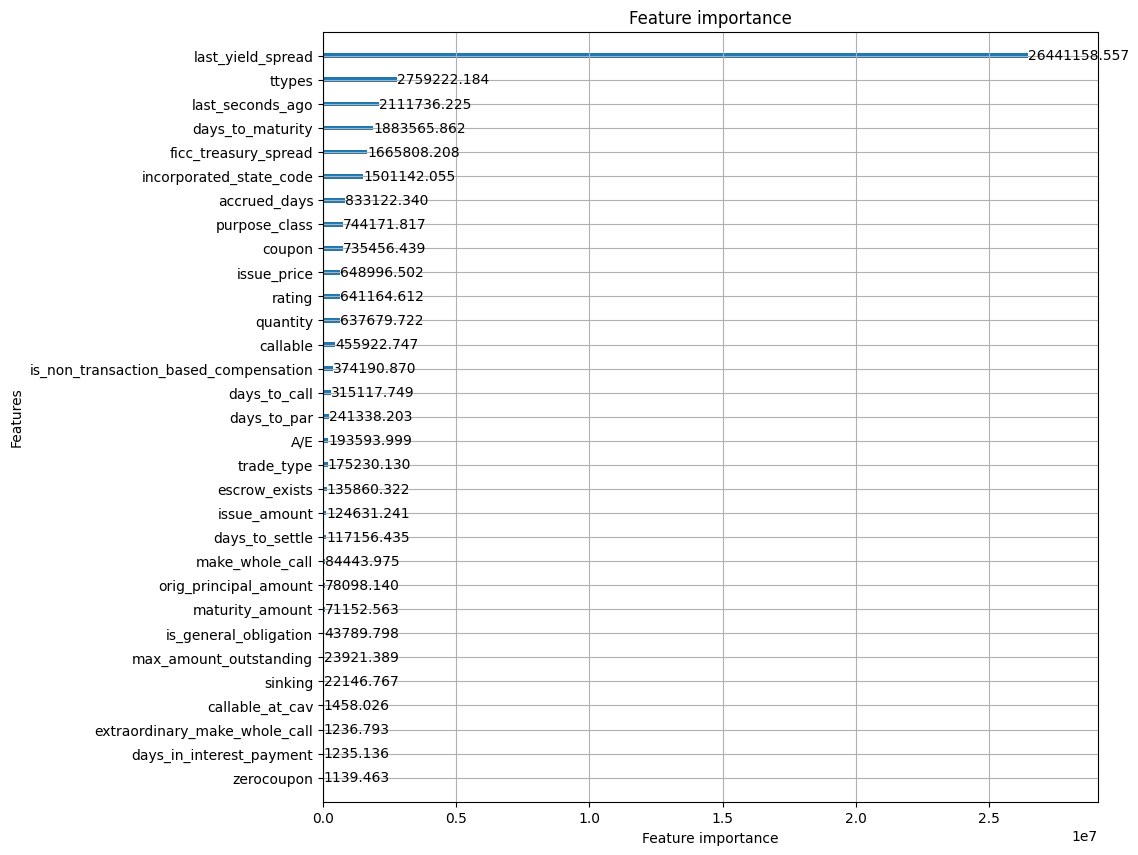

In [53]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10), importance_type='gain')

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [54]:
# Normalization layer for the trade history
# trade_history_normalizer = Normalization(name='Trade_history_normalizer')
# trade_history_normalizer.adapt(x_train[0], batch_size=BATCH_SIZE)
trade_history_normalizer = Normalization(name='Trade_history_normalizer', mean=x_train[0].mean(), variance=x_train[0].var())    # pass in mean and variance instead of calling .adapt(...) to prevent infinite loop

In [55]:
# Normalization layer for the non-categorical and binary features
# noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
# noncat_binary_normalizer.adapt(x_train[2], batch_size=BATCH_SIZE)
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer', mean=x_train[2].mean(), variance=x_train[2].var())    # pass in mean and variance instead of calling .adapt(...) to prevent infinite loop

#### Setting the seed for intialization of the layers

In [56]:
tf.keras.utils.set_random_seed(10)

#### Attention layer
This is an implementation of a layer that calculates scaled dot product attention. 

In [57]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth, name='weights_query') 
        self.wk = layers.Dense(depth, name='weights_key')
        self.wv = layers.Dense(depth, name='weights_value')

    def scaled_dot_product_attention(self, q, v, k):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v, k):
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)

        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model

In [58]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(SEQUENCE_LENGTH, 3), 
                                   dtype = tf.float32)

print('Finished creating input layer initializations')

inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))

noncat_binary_normalized = inputs[2]    # noncat_binary_normalizer(inputs[2])

print('Finished normalizing the the noncat and binary features')

layer.append(noncat_binary_normalized)
####################################################

print('Finished creating input block')

############## TRADE HISTORY MODEL #################

lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         return_sequences = True,
                         name='LSTM')

lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           return_sequences = False,
                           name='LSTM_2')

trade_history_normalized = inputs[0]    # trade_history_normalizer(inputs[0])

print('Finished normalizing the trade history')

features = lstm_layer(trade_history_normalized)
features = lstm_attention_layer(features, features, inputs[1])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

print('Finished first batch normalization in the LSTM')

features = lstm_layer_2(features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

print('Finished second batch normalization in the LSTM')

trade_history_output = layers.Dense(100, 
                                    activation='relu')(features)

####################################################

print('Finished creating trade history model')

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                    input_length= 1,
                                                                    name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

####################################################

print('Finished creating reference data model')

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu')(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh')(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

Finished creating input layer initializations
Finished normalizing the the noncat and binary features
Finished creating input block
Finished normalizing the trade history
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Finished first batch normalization in the LSTM


In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [ ]:
fit_callbacks = [
    #WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [ ]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

#### Plotting train vs validation loss

In [ ]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Gigaflops for one epoch of training

In [ ]:
avg_time = np.mean(time_callback.times)

In [ ]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

### Test accuracy on the entire test set

#### Treasury spread examples

| Test data description                  |Target      | Accuracy  |
|----------------------------------------|------------|-----------|
| Without t-spreads in history           |yield spread| 12.394    |
| T-spreads in history                   |yield spread| 12.061    |
| Without ficc-t spreads                 |yield spread| 11.7402   |
| Ficc-t spreads                         |yield spread| 10.614    |
| Ficc-t spreads                         | same_ys    | **10.4126**|
| Ficc-t spreads with all previous t-rate|yield spread| 10.868    |
| Ficc-t spreads with all previous t-rate| same_ys    | 11.553    |
| Ficc-t spreads with t-difference       |yield spread| 11.2465   |
| Ficc-t spreads with t-difference       | same_ys    | 11.2174   |
| Ficc-t spreads ted rate                |yield spread| 10.5553   |
| Ficc-t spreads ted rate                | same ys    | 10.5462   |
| Ficc-t spreads ted rate corp yield     |yield spread| 11.101    |
| Ficc-t spread corp yield               |same_ys     | 11.018    |

#### Exclusion experiments

| Test data description                  |Target      | Accuracy  | Length of data |
|----------------------------------------|------------|-----------|----------------|
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons|yield spread| 12.649    | 1107493 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> no private placement|yield spread| 12.6413   |1106642 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400|yield spread| 11.787   | 1045766 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400 <br /> removing century bonds|yield spread| 11.787   | 1045632 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400 <br /> removing century bonds <br /> days to maturity < 400|yield spread| 10.88  | 990194 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400 <br /> removing century bonds <br /> days to maturity < 400 <br /> days to refund < 400|yield spread| 10.643 | 988300|
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400 <br /> removing century bonds <br /> days to maturity < 400 <br /> days to refund <400 <br /> Removing territories|yield spread| 10.642 |988076|


In [ ]:
_, mae = model.evaluate(x_test, y_test, verbose=1, batch_size=BATCH_SIZE)
print(f"Test loss: {round(mae, 3)}")
# wandb.log({"Test MAE": mae})

### Accuracy on a daily basis

Measuring the daily accuracy for large dealer dealer trades

In [ ]:
for d in [d for d in pd.date_range(start="11/01/2022",end="11/30/2022",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d) &
                              (test_dataframe.trade_type == 'D') &
                              (test_dataframe.quantity >= np.log10(500000))].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test)
    error = next_day.yield_spread - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

| Test data description                  |Target      | Accuracy  |
|----------------------------------------|------------|-----------|
| Dealer-Dealer treasury spread          |yield spread| 7.592     |
| Dealer-Dealer                          |yield spread| 7.574     |
| Without ficc-t spreads                 |yield spread| 7.685     |
| Ficc-t spreads                         |yield spread|**7.474**  |
| Ficc-t spreads                         | same_ys    | 7.752     |
| Ficc-t spreads with all previous t-rate|yield spread| 8.149     |
| Ficc-t spreads with all previous t-rate| same_ys    | 8.997     |
| Ficc-t spreads with t-difference       |yield spread| 8.854     |
| Ficc-t spreads with t-difference       | same_ys    | 8.790     | 
| Ficc-t spreads ted rate                |yield spread| 7.555     |
| Ficc-t spreads ted rate                | same ys    | 7.863     |
| Ficc-t spreads ted rate corp yield     |yield spread| 8.444     |
| Ficc-t spreads corp yield              | same_ys    | 8.509.    |

#### Exclusion experiments

| Test data description                  |Target      | Accuracy  | Length of data |
|----------------------------------------|------------|-----------|----------------|
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons|yield spread| 9.636    | 13382 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> no private placement|yield spread| 9.640   | 13363
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400|yield spread| 9.276  | 12701 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400 <br /> removing century bonds|yield spread| 9.276   | 12695 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400 <br /> removing century bonds <br /> days to maturity < 400|yield spread| 8.379  | 12273 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400 <br /> removing century bonds <br /> days to maturity < 400 <br /> days to refund < 400|yield spread| 8.299 | 12242 |
| Maturity description code = 2 <br /> No restructured debt <br /> No defaulted bonds <br /> No variable coupons <br /> No private placement <br /> days to call < 400 <br /> removing century bonds <br /> days to maturity < 400 <br /> days to refund <400 <br /> Removing territories|yield spread| 8.229 |12239|


In [ ]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]# & (test_dataframe.coupon == 5)]

In [ ]:
len(true_mid)

In [ ]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.yield_spread

In [ ]:
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Dealer Dealer true mid Test MAE": mae})

### Alternative evaluation set
Experiment with other conditions. From the error analysis notebook, it was observed that we do better with coupon rate of 5%.

In [ ]:
temp_test = test_dataframe[(test_dataframe['coupon'] == 5)]

In [ ]:
len(temp_test)

In [ ]:
%%time
x_temp_test = create_input(temp_test)
y_temp_test = temp_test.yield_spread

5% - 11.269 \
4% - 10.580 \
3% - 14.090

In [ ]:
_, mae = model.evaluate(x_temp_test, y_temp_test, verbose=1, batch_size=1000)
print(f"Test MAE: {round(mae, 3)}")

# Saving the model

In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders_{file_timestamp}.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'ficc-ml-models', f"encoders_{file_timestamp}.pkl")

print("Saving and uploading model")
model.save(f"saved_model_test_{file_timestamp}")
import shutil
shutil.make_archive(f"model_dec_30", 'zip', f"saved_model_test_{file_timestamp}")
upload_data(storage_client, 'ficc-ml-models', f"model_dec_30.zip")

### Plotting trades above a threshold

In [ ]:
%time preds = model.predict(x_test)
preds = preds.reshape(len(preds))
error = test_dataframe.yield_spread - preds
MAE = np.mean(np.abs(error))
print(MAE)

In [ ]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e7

# plot points with transparency depending on size of trade
def drawpoints(preds, target, dataframe):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (10**dataframe.quantity > threshold/10)  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    
    print(f"Max prediction : {max(preds[keep])} Min predicton: {min(preds[keep])}")
    print(f"Length of dataframe: {len(dataframe)}")
    
    plt.figure(figsize=(5, 5))
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    plt.xlabel('Predicted')
    plt.ylabel('Target')

drawpoints(preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread

In [ ]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

# drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread on dealer dealer true mid trades

In [ ]:
dd_dataframe = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
dd_last_ys_preds = dd_dataframe.last_yield_spread
error = dd_dataframe.yield_spread - last_ys_preds


MAE = np.mean(np.abs(error))
print(MAE)

# drawpoints(dd_last_ys_preds , dd_dataframe.yield_spread, dd_dataframe)

### Regression baseline using previous yield spread optimizing MAE

In [ ]:
from statsmodels.regression.quantile_regression import QuantReg

In [ ]:
q_reg = QuantReg(train_dataframe.last_yield_spread, train_dataframe.yield_spread)

In [ ]:
res = q_reg.fit(q=.5)

In [ ]:
predicted_yield_spread = res.predict(test_dataframe.last_yield_spread)
actual_yield_spread = test_dataframe.yield_spread.values

In [ ]:
MAE = np.mean(np.abs(actual_yield_spread - predicted_yield_spread))
print(MAE)

In [ ]:
print(f'Regression coefficient {res.params[0]}')

In [ ]:
x_range = np.arange(-20,300)
y_straight = x_range.copy()

In [ ]:
y_mae_regression = res.params[0] * x_range

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(test_dataframe.last_yield_spread, actual_yield_spread, s=5)
plt.plot(x_range, y_mae_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

#### GBM true mid baseline

In [ ]:
temp_test =  test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]

In [ ]:
len(temp_test)

In [ ]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(temp_test[PREDICTORS]) )
delta = temp_test.yield_spread - gbt_pred
print(delta.abs().mean() )

#### Analyzing the test set

In [ ]:
test_preds = model.predict(x_test)

In [ ]:
evaluation_dataframe = test_dataframe.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [ ]:
from ficc.utils.diff_in_days import diff_in_days_two_dates
from ficc.utils.auxiliary_variables import NUM_OF_DAYS_IN_YEAR

def calculate_dollar_error(df):
    years_to_calc_date = diff_in_days_two_dates(df.calc_date,df.trade_date) / NUM_OF_DAYS_IN_YEAR    # the division by `np.timedelta64(NUM_OF_DAYS_IN_YEAR, 'D')` converts the quantity to years according to the MSRB convention of NUM_OF_DAYS_IN_YEAR in a year
    ytw_error = ((df['predicted_yield_spreads'] + df['ficc_ycl']) / 100 - df['yield']) / 100    # the second divide by 100 is because the unit of the dividend is in percent
    return ytw_error * (df['quantity']) * years_to_calc_date 

In [ ]:
evaluation_dataframe['dollar_error'] = evaluation_dataframe.parallel_apply(calculate_dollar_error, axis=1)

In [ ]:
temp_df = evaluation_dataframe[(evaluation_dataframe.trade_date == '2022-11-29') &
                               (np.abs(evaluation_dataframe.delta_yield_spreads) > 30) &
                               (evaluation_dataframe.coupon == 5) &
                               (evaluation_dataframe.quantity >= np.log10(500000)) &
                               (evaluation_dataframe.trade_type == 'D') ]

temp_df = temp_df.sort_values('delta_yield_spreads', ascending=False)
display(temp_df)
# temp_df.to_csv('temp.csv', index=False)

In [ ]:
np.std(evaluation_dataframe.delta_yield_spreads)

In [ ]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

#### Isolating trades with error greater than 50 bps

In [ ]:
evaluation_dataframe['delta_last_yield_spread'] = np.abs(evaluation_dataframe.yield_spread - evaluation_dataframe.last_yield_spread)

In [ ]:
temp_20 = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 20) | (evaluation_dataframe.delta_yield_spreads < -20)  ]
temp_20 = temp_20.sort_values('delta_yield_spreads',ascending=False)
temp_20.to_csv('greater_than_20.csv',index=False)

#### Isolating trades with error less than 3 bps

In [ ]:
temp_3 = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads < 3) & (evaluation_dataframe.delta_yield_spreads > -3)  ]
temp_3 = temp_3.sort_values('delta_last_yield_spread',ascending=False)
temp_3.to_csv('less_than_3.csv',index=False)